In [1]:
DEV_PATH = '/home/frossi/dev/'
import sys
if not DEV_PATH in sys.path:
    sys.path.append(DEV_PATH)

from mavis import *

In [2]:
rh1 = mf['ZernikeCovarianceD'].rhs
lh1 = mf['ZernikeCovarianceD'].lhs
display(lh1)
display(rh1)

dW_phi(rho)

0.0229*(-1)**m_k*2**(-0.5*KroneckerDelta(0, m_j) - 0.5*KroneckerDelta(0, m_k) + 1)*I**(n_j + n_k)*sqrt((n_j + 1)*(n_k + 1))*(I**(3*m_j + 3*m_k)*cos(theta*(m_j + m_k) + pi*((1 - KroneckerDelta(0, m_j))*((-1)**j - 1) + (1 - KroneckerDelta(0, m_k))*((-1)**k - 1))/4)*besselj(m_j + m_k, 2*pi*f*h*rho) + I**(3*Abs(m_j - m_k))*cos(theta*(m_j - m_k) + pi*((1 - KroneckerDelta(0, m_j))*((-1)**j - 1) - (1 - KroneckerDelta(0, m_k))*((-1)**k - 1))/4)*besselj(Abs(m_j - m_k), 2*pi*f*h*rho))*besselj(n_j + 1, 2*pi*R_1*f)*besselj(n_j + 1, 2*pi*R_2*f)/(pi*R_1*R_2*f*r_0**(5/3)*((1/L_0)**2 + f**2)**(11/6))

-0.265730960724332*besselj(2, 8.0*pi*f)**2*besselj(2, 20000*pi*f*rho)/(pi*f*(f**2 + 0.00206611570247934)**(11/6))

Integral(-0.265730960724332*besselj(2, 8.0*pi*f)**2*besselj(2, 20000*pi*f*rho)/(pi*f*(f**2 + 0.00206611570247934)**(11/6)), (f, 0.001, 10))

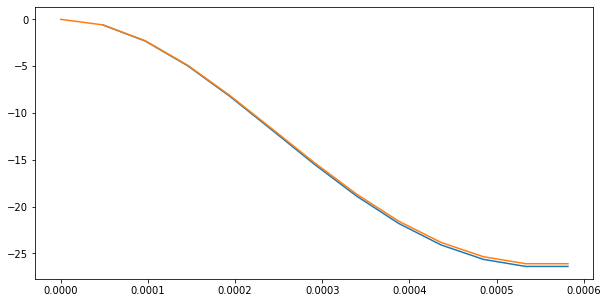

In [3]:
# Noll indices: i,j = 2,3 : OK
# L0 = 22.0 : OK
# r_0 = calcolare da Cn2 (0.1) # OK
# h = 10000 : OK 
# rho max: 120 asec (convertito in radianti)
# theta= pi/4 : OK
# f = [1e-3, 1] : OK
paramsDict = {'theta': np.pi/4.0, 'L_0': 22.0, 'r_0': 0.1, 'R_1': TelescopeDiameter/2.0, 'R_2': TelescopeDiameter/2.0, 'h': DM_height }
#, 'f_min': 1e-3, 'f_max': 1e3
_integrationLimits = (sp.symbols('f', positive=True) , 1e-3, 10)

_integrand1 = subsParamsByName(cov_expr_jk(rh1, 3, 2), paramsDict)
display(_integrand1)

mItCPU = Integrator('none', np, np.float64)
# usando GPU ho un valore costante: debug: solved!
mItGPU = Integrator('none', cp, cp.float64)
mIt = mItGPU

fig, ax = plt.subplots(figsize=(10,5))
plt.xscale('linear')
plt.yscale('linear')
_integral1 = sp.Integral(_integrand1, _integrationLimits)
display(_integral1)
xplot1, zplot1 = mIt.IntegralEval(lh1, _integral1, [('rho',  0, 120.0/ 206265.0, 13, 'linear')], [(1025, 'linear')], method='rect')
xx, zz = cp.asnumpy(xplot1[0]), cp.asnumpy(zplot1)
ax.plot(xx, zz )
hdul = fits.open('MAVIS_TESTS/ex_covar.fits')
cv_plot = np.asarray(hdul[0].data, np.float64)
ax.plot(xx, cv_plot)
plt.show()

#_lhs = sp.symbols('C_v', positive=True)
#_rhs = _integrand1
#_eq = sp.Eq(_lhs, _rhs)
#myF = Formulary('local', ['ZernikeCoval'], [(_lhs, _rhs, _eq)])
#myF.plotFormula('ZernikeCoval',
#            {'rho': 60.0/ 206265.0},
#            ['f'],
#            [ np.asarray(np.geomspace(1e-3, 10, 1024*2), dtype=np.float64) ],
#            ["scipy", pplib], False)

In [4]:
rh1 = MavisFormulas.getFormulaRhs('ZernikeCovarianceD')
lh1 = MavisFormulas.getFormulaLhs('ZernikeCovarianceD')
mIt = Integrator('none', np, np.float64)
_integrationLimits = (sp.symbols('f', positive=True), 1e-3, 10.0)

cartesianCoordsViewingDirection = np.asarray([5,5]) # x, y
polarCoordsViewingDirection = cartesianToPolar(cartesianCoordsViewingDirection) # rho, theta
scaleF = (500.0/(2*np.pi))**2

def covValue(ii,jj, polarCoordsViewingDirectionDifference, li):        
    paramsDict = {'theta': polarCoordsViewingDirectionDifference[1]*degToRad, 'L_0': L0_Value, 'r_0': r0_Value, 
                  'R_1': TelescopeDiameter/2.0, 'R_2': TelescopeDiameter/2.0, 'h': heights_Cn2[li] }
    _integrand1 = subsParamsByName(cov_expr_jk(rh1, ii, jj), paramsDict)
    _integral1 = sp.Integral(_integrand1, _integrationLimits)
    xplot1, zplot1 = mIt.IntegralEval(lh1, _integral1, 
                                      [('rho',  polarCoordsViewingDirectionDifference[0]*arcsecsToRadians, 
                                                         polarCoordsViewingDirectionDifference[0]*arcsecsToRadians, 1, 'linear')], 
                                      [(10000, 'linear')], method='rect')
    return zplot1[0]

matCaaValue = np.zeros((2,2), dtype=np.float64)
for ii in [2,3]:
    for jj in [2,3]:
        matCaaValue[ii-2][jj-2] = scaleF*covValue(ii,jj, cartesianToPolar(np.asarray([0,0])), 2)
print(matCaaValue)

matCasValue = np.zeros((2,6), dtype=np.float64)

for li in [0,1]:
    for kk in [0,1,2]:
        asterismStar = cartTestNGSCoords[kk]
        polarCoordsViewingDirection = cartesianToPolar(-asterismStar+cartesianCoordsViewingDirection)
        for ii in [2,3]:
            for jj in [2,3]:
                matCasValue[ii-2][jj-2 + 2*kk] += Cn2_Value[li]*scaleF*covValue(ii, jj, polarCoordsViewingDirection, li)

print(matCasValue)

matCssValue = np.zeros((6,6), dtype=np.float64)
for li in [0,1]:
    for kk1 in [0,1,2]:
        for kk2 in [0,1,2]:
            polarCoordsViewingDirection = cartesianToPolar(cartTestNGSCoords[kk1]-cartTestNGSCoords[kk2])
            for ii in [2,3]:
                for jj in [2,3]:
                    matCssValue[ii-2 + 2*kk1][jj-2 + 2*kk2] += Cn2_Value[li]*scaleF*covValue(ii,jj, polarCoordsViewingDirection, li)
print(matCssValue)

# con queste assemblo C2

[[302248.69732678      0.        ]
 [     0.         302248.69732678]]
[[256824.00448625   5843.96994537 248481.62949499  21973.7073617
  289824.0961      -6850.35473328]
 [  5843.96994537 284875.06022403  21973.7073617  184228.2471212
   -6850.35473328 285481.14522403]]
[[302248.69732678      0.         185499.22872774  52891.90329607
  220641.19037457 -12634.04523973]
 [     0.         302248.69732678  52891.90329607 159721.98380109
  -12634.04523973 268574.96084958]
 [185499.22872774  52891.90329607 302248.69732678      0.
  234665.79198476   6420.69651042]
 [ 52891.90329607 159721.98380109      0.         302248.69732678
    6420.69651042 134117.8207296 ]
 [220641.19037457 -12634.04523973 234665.79198476   6420.69651042
  302248.69732678      0.        ]
 [-12634.04523973 268574.96084958   6420.69651042 134117.8207296
       0.         302248.69732678]]


In [5]:
hdul = fits.open('MAVIS_TESTS/Caa.fits')
Caa_data = np.asarray(hdul[0].data, np.float64)
print((Caa_data-matCaaValue)/np.amax(Caa_data))
hdul = fits.open('MAVIS_TESTS/Cas.fits')
Cas_data = np.asarray(hdul[0].data, np.float64)
print((Cas_data-matCasValue)/np.amax(Cas_data))
hdul = fits.open('MAVIS_TESTS/Css.fits')
Css_data = np.asarray(hdul[0].data, np.float64)
print((Css_data-matCssValue)/np.amax(Css_data))

[[-1.98230445e-04  6.12323363e-17]
 [ 6.12323363e-17 -1.98230445e-04]]
[[-1.68123269e-04 -4.58858877e-06 -1.65317050e-04 -1.48263937e-05
  -1.93930832e-04  4.79052122e-06]
 [-4.58858877e-06 -1.90192943e-04 -1.48263937e-05 -1.21968180e-04
   4.79052122e-06 -1.90914741e-04]]
[[-1.98230445e-04  6.12323363e-17 -1.21607260e-04 -3.02318517e-05
  -1.41167081e-04  7.85676047e-06]
 [ 6.12323363e-17 -1.98230445e-04 -3.02318517e-05 -1.06870203e-04
   7.85676047e-06 -1.70955799e-04]
 [-1.21607260e-04 -3.02318517e-05 -1.98230445e-04  6.12323363e-17
  -1.49764623e-04 -3.77067411e-06]
 [-3.02318517e-05 -1.06870203e-04  6.12323363e-17 -1.98230445e-04
  -3.77067411e-06 -9.06923250e-05]
 [-1.41167081e-04  7.85676047e-06 -1.49764623e-04 -3.77067411e-06
  -1.98230445e-04  6.12323363e-17]
 [ 7.85676047e-06 -1.70955799e-04 -3.77067411e-06 -9.06923250e-05
   6.12323363e-17 -1.98230445e-04]]
